<a href="https://colab.research.google.com/github/smartgrids-aau/GreenCodesPython/blob/main/Exemple_4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

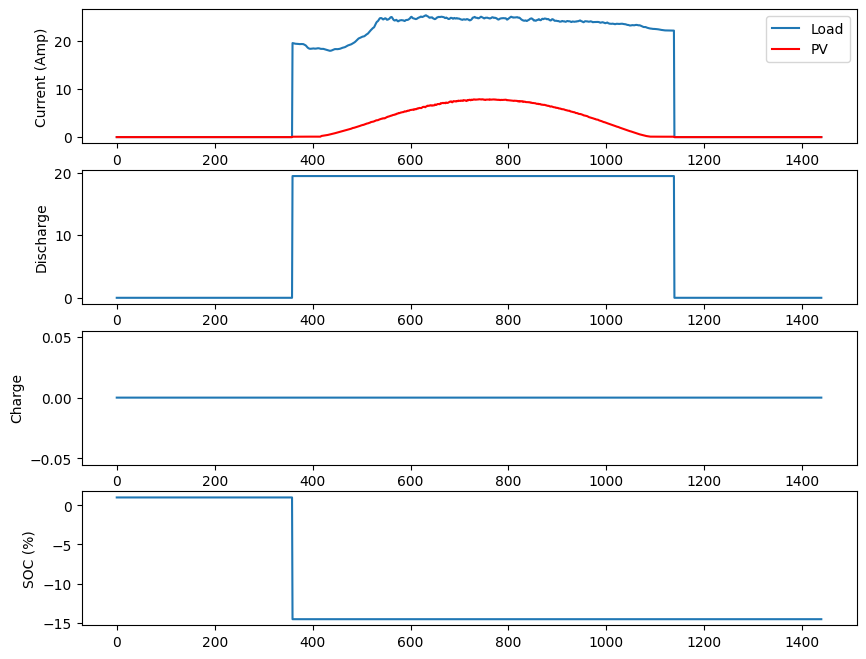

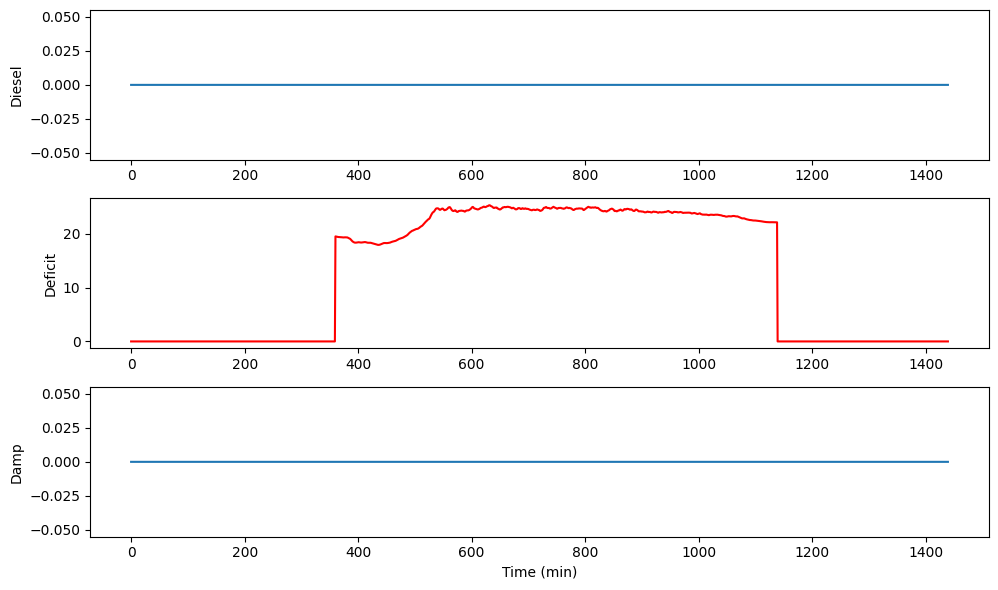

In [19]:
# Exercise 4.3

import pandas as pd
import matplotlib.pyplot as plt

file_path = 'PV Modeling Book Data Source.xls'
sheet_name = 'Source 2'

df = pd.read_excel(file_path, sheet_name=sheet_name, usecols="B:C", skiprows=1, nrows=1440)
I_L = df.iloc[:, 0].values
I_PV = df.iloc[:, 1].values

# System specifications
I_Diesel = 5
SOCmax = 1000
SOCi = SOCmax
V_B = 2
DOD = 0.8
SOCmin = SOCmax * (1 - DOD)
t1 = 1
SOC1 = 1
SOC3 = 0.3
K = 0.8
D = 1e-5
ns = 6
SOC2 = SOC1
W = 0
A = 0.2461
T = 0.081451
n = 0

# Storage
SOCf = []
I_Loadf = []
I_Chargef = []
I_Dischargef = []
I_Batteryf = []
I_Deficitf = []
I_Dampf = []
I_Dieself = []
F_Cf = []

# Simulation
I_net = I_PV - I_L
SOC_track = []

for i in range(len(I_L)):
    if len(SOCf) == 0:
        prev_SOC = SOC1
    else:
        prev_SOC = SOCf[-1]

    if I_net[i] == 0 and n == 0:
        I_Loadi = I_PV[i]
        I_Dampi = I_Batteryi = I_Chargei = I_Deficiti = I_Dieseli = I_Dischargei = F_Ci = 0
        if i == 0 or W == 0:
            SOCi = SOC1
        elif W == 1:
            SOCi = prev_SOC

    elif I_net[i] > 0 and n == 0:
        I_Loadi = I_L[i]
        if i == 0 or W == 0:
            SOCi = SOC1
            I_Dampi = I_net[i]
            I_Chargei = I_Dischargei = I_Batteryi = I_Deficiti = I_Dieseli = F_Ci = 0
        elif W == 1:
            if prev_SOC >= SOC1:
                I_Dampi = I_net[i]
                SOCi = prev_SOC
                I_Dischargei = I_Batteryi = I_Deficiti = I_Dieseli = I_Chargei = F_Ci = 0
            else:
                I_Chargei = I_net[i]
                I_Dischargei = I_Batteryi = I_Deficiti = I_Dieseli = I_Dampi = F_Ci = 0
                SOCi = prev_SOC + abs(SOC1 - (SOC1 + I_Chargei * K))

    elif I_net[i] < 0 or (I_net[i] > 0 and n > 0):
        if W == 0 and n == 0:
            I_Dischargei = I_L[i] - I_PV[i]
            I_Loadi = I_PV[i] + I_Dischargei
            I_Batteryi = I_Dischargei
            I_Chargei = I_Deficiti = I_Dampi = I_Dieseli = F_Ci = 0
            SOCi = SOC1 - abs(SOC1 - (SOC1 - I_Dischargei * K))
            W += 1
        elif W == 1:
            if prev_SOC > SOC3 and n == 0:
                I_Dischargei = I_L[i] - I_PV[i]
                I_Loadi = I_L[i]
                I_Batteryi = I_Dischargei
                I_Chargei = I_Deficiti = I_Dampi = I_Dieseli = F_Ci = 0
                SOCi = prev_SOC - abs(SOC1 - (SOC1 - I_Dischargei * K))
            elif prev_SOC <= SOC3 or n > 0:
                if I_Diesel >= I_L[i]:
                    I_Loadi = I_L[i]
                    I_Dieseli = I_Loadi
                    I_Dischargei = I_Deficiti = 0
                    if prev_SOC < SOC1:
                        I_Chargei = I_PV[i]
                        I_Dampi = 0
                        SOCi = prev_SOC + abs(SOC1 - (SOC1 + I_Chargei * K))
                    else:
                        I_Chargei = 0
                        I_Dampi = I_PV[i]
                        SOCi = prev_SOC
                    F_Ci = A * (230 * ((I_Dieseli / 60) / 1000)) + T * (230 * ((I_Diesel / 60) / 1000))
                    n += 1
                elif I_Diesel < I_L[i]:
                    I_Deficiti = I_L[i]

                if n == 4:
                    n = 0

    SOCf.append(SOCi)
    I_Loadf.append(I_Loadi)
    I_Chargef.append(I_Chargei)
    I_Dischargef.append(I_Dischargei)
    I_Batteryf.append(I_Batteryi)
    I_Deficitf.append(I_Deficiti)
    I_Dampf.append(I_Dampi)
    I_Dieself.append(I_Dieseli)
    F_Cf.append(F_Ci)

# Final results
Excess_energy = ((sum(I_Dampf) / 60) * 220) / 1000
Diesel_consumption = sum(F_Cf)
Enrgy_Deficit = ((sum(I_Deficitf) / 60) * 220) / 1000
Enrgy_Discharge = ((sum(I_Dischargef) / 60) * 220) / 1000

# Plotting
fig1, axs1 = plt.subplots(4, 1, figsize=(10, 8))
axs1[0].plot(I_L, label='Load')
axs1[0].plot(I_PV, label='PV', color='red')
axs1[0].set_ylabel('Current (Amp)')
axs1[0].legend()

axs1[1].plot(I_Dischargef)
axs1[1].set_ylabel('Discharge')

axs1[2].plot(I_Chargef)
axs1[2].set_ylabel('Charge')

axs1[3].plot(SOCf)
axs1[3].set_ylabel('SOC (%)')

fig2, axs2 = plt.subplots(3, 1, figsize=(10, 6))
axs2[0].plot(I_Dieself)
axs2[0].set_ylabel('Diesel')

axs2[1].plot(I_Deficitf, color='red')
axs2[1].set_ylabel('Deficit')

axs2[2].plot(I_Dampf)
axs2[2].set_ylabel('Damp')
axs2[2].set_xlabel('Time (min)')

plt.tight_layout()

